# CSE527 Homework 4
**Due date: 23:59 on Nov. 5, 2019 (Thuesday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 16-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [0]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import time
import pickle

import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [1]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
# Set your working directory (in your google drive)
# Note that 'gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/hw4' is just an example, 
#   change it to your specific homework directory.
# cd '/content/gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/hw4'
# cd /gdrive/My Drive/Singh_Yasha_112970310_hw4
# cd gdrive/My\ Driive
cd CV/Singh_Yasha_112970310_hw4/

/content/gdrive/My Drive/CV/Singh_Yasha_112970310_hw4


In [0]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50


def img_norm(img):
  # Write your code here
  # normalize img pixels to [-1, 1]
  return  2*((img - img.min())/(img.max() - img.min())) - 1

def img_rotate(img):
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False,
                rotate_90=False, zero_centered=False):
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))

    new_data = data[:] # Maintaining a replica to store augmentations on Original images and avoid repetition.

    # Write your Data Augmentation code here
    # mirroring/flipping
    if augment:
      flipped = list()
      for img in data:
        flipped.append(np.flip(img, 1))
      new_data.extend(flipped)
      labels.extend(labels)
    
    # Rotate image
    if rotate_90:
      rotated_data = np.array(list(map(img_rotate, data)))
      new_data.extend(rotated_data)
      labels.extend(labels)

    data = new_data[:] # Replacing the original data with new Augmented data
    del new_data       # Deleting the duplicate variable

    # Write your Data Normalization code here
    # norm data to zero-centered
    if zero_centered:
      data = [image - image.mean() for image in data]
     
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)

    print("total images = %d" % (len(data)))
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Forest', 1: 'Industrial', 2: 'Flower', 3: 'Coast', 4: 'InsideCity', 5: 'Office', 6: 'Bedroom', 7: 'Highway', 8: 'Street', 9: 'TallBuilding', 10: 'LivingRoom', 11: 'Suburb', 12: 'OpenCountry', 13: 'Mountain', 14: 'Kitchen', 15: 'Store'} 


In [0]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

"""
Here we will load the training data in 3 different ways
1. Original images
2. Original + Flipped images + Rotated images
3. Original + Flipped images + Rotated images with each zero_centered normalised

Variant 3 will be used in Part 1 for Problem 1 and
all the variants (1, 2 and 3) will be used for comparision in Part 2 of Problem 1.
"""

# load training dataset (Original images only)
trainloader_plain = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True))
train_num = len(trainloader_plain)
print("Finish loading %d minibatches(=%d) of training samples.\n" % (train_num, batch_num))

# load training dataset (Original + Flipped images + Rotated Images)
trainloader_augmented = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, rotate_90=True))
train_num = len(trainloader_augmented)
print("Finish loading %d minibatches(=%d) of training samples.\n" % (train_num, batch_num))

# load training dataset (Original + Flipped images + Rotated Images with each image Zero_centered normalized)
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, rotate_90=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples.\n" % (train_num, batch_num))

# load testing dataset (One with zero-centered normalisation and other without normalised)
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num,
                                     zero_centered=False))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

testloader_small_norm = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num,
                                     zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))


Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
total images = 2400
Finish loading 48 minibatches(=50) of training samples.

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading image

In [0]:
# Creating pickle for fast data loading
# file = open('hw4_data.pkl','wb')
# pickle.dump(trainloader_plain, file)
# pickle.dump(trainloader_augmented, file)
# pickle.dump(trainloader_small, file)
# pickle.dump(testloader_small, file)
# pickle.dump(testloader_small_norm, file)
# file.close() 

file = open('hw4_data.pkl', 'rb')
trainloader_plain = pickle.load(file)
trainloader_augmented = pickle.load(file)
trainloader_small = pickle.load(file)
testloader_small = pickle.load(file)
testloader_small_norm = pickle.load(file)
file.close()

Forest


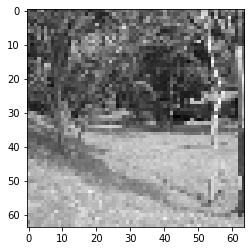

In [0]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 16-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

<hr>
<hr>
<hr>
<hr>

# **Solution of Problem 1**
<br>

## <u>Part 1 - Data and Network/Model description</u>
<br>

**1. DATA AUGMENTATION:** <br>
We originally have 2400 training images which belong to 16 classes. In order to train the model better and increase training accuracy, we augment the original data and append/extend the size of our data. Here, we have used two techniques for this task- **Image Flipping** and **Image Rotation**. In order to analyse the affect in model performance with data augmentation, entire augmented data was loaded in two forms- one normalised and other not-normalised to zero-center.
This step increases our training data as follows :  
```
trainloader_plain     = (2400) Original images only 
trainloader_augmented = (7200) Original + Flipped images + Rotated Images 
trainloader_small     = (7200) Original + Flipped images + Rotated Images with each image Zero_centered normalized   
```
<br>

**2. DATA NORMALIZATON:**<br>
By default, images have varying intensities and varying range of pixel values. Due to this difference in ranges, while trainnig neural networks, gradients may take long time and struggle more to find the optimum solution. Normalizing shifts the entire feature space into one common range. Hence results in faster and more accurate convergence.  
<u>Here, Images are normalised in two folds</u>
```
1. Normalizing image pixels in range [-1, 1] inclusive.  
2. Zero centered normalization - Each image is subtracted from it's mean value.
```
<br>

**3. MODEL CONFIGURATION:**<br>
Implemented a basic Convolutional Neural Network (CNN) model for classification purpose using PyTorch.
Our network consists of three Sequential layers:  

- **Layer 1 (Sequential Convolutional Layer)**  
A Sequential layer which consists of a ```Conv2d``` layer with a 5x5 kernel and a 2 stride steps. This is followed by ```ReLU``` activation,```BatchNorm2d``` batch-normalisation and a ```MaxPooling2d``` pooling layer.  
This layer takes in **input as image with 1 channel** and **transforms them to 16 channels**. This is the base layer for feature extraction from our data.

- **Layer 2 (Dropout Layer)**  
For network regularization, a ```Dropout``` layer is added with dropout rate ```p=0.5```. For observing its affect on training, a boolean variable ```dropout_flag``` is used to control the availability of this layer. If ```dropout_flag=False```, this layer will be bypassed and we may train the network to study the model performance in its absence. If ```dropout_flag=True```, outputs from ```layer 1``` will be passed to this dropout layer and model will be trained accordingly.  

- **Layer 3 (Sequential Convolutional Layer)**  
Composition of this layer is same as ```layer 1``` but it accepts inputs with 16 dimentions and converts them to 8 dimentions outputs. This layer acts as the final layer for our feature extraction.  

- **Layer 4 (Classifier)**  
This is the final classification layer for the model where the features are first flatten into a linear vector of length 288 and then passed through a ```Linear``` layer which converts the vector into our desired output vector of length 16, i.e. the number of classes in our classification task!


### Model Performance (For PART 1)  
Data (7200 images) = Original + Flipped + Rotated with each image normalised to zero-ceter.  
Dropout layer enabled before last convolutional layer.  
Results after training the model for **30 epochs** with **GPU enabled**,  
**Best Results:-**
```
Accuracy         =   56.2500 %
Training-time    =   28.2140 sec
Evaluation-time  =   0.0284 sec
```
<hr><br>

## <u>Part 2 - Studying the affects of diferent Techniques to **Increase the model performance**</u>

> Note:- Training was performed with **GPU enabled** hence processing time are very less.

For relative comparision, a **baseline accuracy was achieved by training our model with only Original images**. Based on its result, other methods were compared and tagged if they improved the performance or failed.  
**Baseline (Training with only Original Images)**
```
Accuracy         =   43.0000 %
Training-time    =   9.2040 sec
Evaluation-time  =   0.0276 sec
```
- **Method 1 (Data augmentation without Normalization)**  
We extended the original data with flipped and rotated images without zero-centered normalization since we wish we obser the sole effect of data augmentation on model performance. Results are as follows:- 
```
Accuracy         =   47.5000 %
Training-time    =   26.5740 sec
Evaluation-time  =   0.0279 sec
```

- **Method 2 (Different model Optimization functions)**
4 different model optimizers- SGD, Adadelta, RMSprop and Adam, were tried with same learning rate ```lr=0.001```. 
<u> **Adam** Optimizer resulted with highest accuracy</u>, followed by **RMSprop**. <br>
<u>Adam optimizer (comparitively best) result:-</u>
```
Accuracy         =   51.00 %
Training-time    =   27.03 sec
Evaluation-time  =   0.0274 sec
```

<table class="table">
  <th>
    <td><b>  SGD      </b></td>
    <td><b>  Adadelta </b></td>
    <td><b>  RMSprop  </b></td>
    <td><b>  Adam     </b></td>
  </th>
  <tr>
    <td><b>  Accuracy   </b></td>
    <td>43.25 %  </td>
    <td>10.50 %  </td>
    <td>48.25 %  </td>
    <td>51.00 % </td>
  </tr>
  <tr>
    <td><b> Training Time </b></td>
    <td>24.89 sec     </td>
    <td>27.78 sec     </td>
    <td>26.18 sec    </td>
    <td>27.03 sec    </td>
  </tr>
  <tr>
    <td><b>  Eval Time   </b></td>
    <td>0.0274 sec  </td>
    <td>0.0277 sec  </td>
    <td>0.0298 sec  </td>
    <td>0.0274 sec  </td>
</table>

- **Method 3 (Network Regularization)**
Here the ```Dropout``` layer with dropout rate ```p=0.5``` was enabled before last ```Conv2d``` layer. The data was Augmented and zero-centered Normalised. <u>**This configuration resulted in maximum accuracy**</u><br>

```
Accuracy         =   56.2500
Training-time    =   28.2140 sec
Evaluation-time  =   0.0284 sec
```

<br>

In [0]:
# ==========================================
#       Define Network Architecture
# ==========================================

class CNN_Model(nn.Module):
  def __init__(self, dropout_flag=False):
    super(CNN_Model, self).__init__()
    self.dropout_flag = dropout_flag
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=5, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2)
    )
    self.dropout1 = nn.Dropout(p=0.5)
    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 8, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(8),
        nn.MaxPool2d(kernel_size=2)
    )
    self.layer3 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(288, 16)
    )

  def forward(self, x):
    x = self.layer1(x)
    if self.dropout_flag:
      x = self.dropout1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    return x
  

In [0]:
# ==========================================
#         Optimize/Train Network
# ==========================================

def train_network(net, loss_function, train_data, epochs, optimizer):
  losses = []
  accuracies = []
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  net.to(device)
  print("GPU enabled training = {}".format(torch.cuda.is_available()))
  t0 = time.time()
  for epoch in range(epochs):
    net.train()
    acc = 0
    total = 0
    for i, data in enumerate(train_data, 0):
      image, label = data
      image, label = image.float().to(device), label.to(device)
      optimizer.zero_grad()
      outputs = net(image)
      loss = loss_function(outputs, label)
      loss.backward()
      optimizer.step()
      _, predictions = torch.max(outputs.data, 1)
      acc += torch.sum(predictions == label).item()
      total+=label.size(0)
    accuracies.append(100*acc/total)
    losses.append(loss.item())
    print('Epoch = {},\tLoss = {:.4f},\tTraining accuracy = {:.4f}'.format(epoch + 1, loss.item(), accuracies[-1]))
  t = time.time()-t0
  print("**** TOTAL TRAINING TIME : {} sec.*****".format(round(t,3)))
  return (accuracies, losses, round(t,3))

In [0]:
# ==========================================
#            Evaluating Network
# ==========================================

def evaluate_model(net, test_data):
  corr_predictions = 0
  total = 0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  net.to(device)
  t0 = time.time()
  net.eval()
  with torch.no_grad():
    for data in test_data:
      image, label = data
      image, label = image.float().to(device), label.to(device)
      outputs = net(image)
      _, predicted = torch.max(outputs.data, 1)
      total += label.size(0)
      corr_predictions += torch.sum(predicted == label).item()
  t = time.time()-t0
  return ((100 * corr_predictions / total), t)

In [0]:
# ==========================================
#       Part 1 : Evaluate Model with all required arguments:-
#       
#       Augmented (flipped and rotated) with each image Zero-centered Normalised
#       and Network Regularisation (dropout layer enabled)
# ==========================================

net = CNN_Model(dropout_flag=True)
loss_fn = nn.CrossEntropyLoss()
epochs = 30
optimizer = optim.Adam(net.parameters())
acc, loss, train_time = train_network(net, loss_fn, trainloader_small, epochs, optimizer)
test_accuracy, eval_time = evaluate_model(net, testloader_small_norm)
print("Model accuracy= {:.4f}. Training Time= {:.4f} sec and Evaluation time={:.4f} sec".format(test_accuracy, train_time, eval_time))

GPU enabled training = True
Epoch = 1,	Loss = 2.2180,	Training accuracy = 20.5417
Epoch = 2,	Loss = 1.8499,	Training accuracy = 34.4167
Epoch = 3,	Loss = 1.7668,	Training accuracy = 41.7639
Epoch = 4,	Loss = 1.7440,	Training accuracy = 44.6944
Epoch = 5,	Loss = 1.6625,	Training accuracy = 46.6389
Epoch = 6,	Loss = 1.6103,	Training accuracy = 48.5000
Epoch = 7,	Loss = 1.5134,	Training accuracy = 50.2639
Epoch = 8,	Loss = 1.7068,	Training accuracy = 51.6806
Epoch = 9,	Loss = 1.6309,	Training accuracy = 52.3472
Epoch = 10,	Loss = 1.5622,	Training accuracy = 53.7778
Epoch = 11,	Loss = 1.4750,	Training accuracy = 54.6944
Epoch = 12,	Loss = 1.4034,	Training accuracy = 55.4722
Epoch = 13,	Loss = 1.4420,	Training accuracy = 55.4444
Epoch = 14,	Loss = 1.3938,	Training accuracy = 56.1250
Epoch = 15,	Loss = 1.5345,	Training accuracy = 57.3611
Epoch = 16,	Loss = 1.3873,	Training accuracy = 56.8750
Epoch = 17,	Loss = 1.4221,	Training accuracy = 57.7083
Epoch = 18,	Loss = 1.3111,	Training accuracy =

In [0]:
# ===================================================
#            Part 2 : Trying 3 Different Techniques
#                     to increase model performance
# ===================================================

###### Training baseline (Original Images only) 
net = CNN_Model(dropout_flag=False)
loss_fn = nn.CrossEntropyLoss()
epochs = 30
optimizer = optim.Adam(net.parameters())
print("Training model with Original images only")
acc0, loss0, train_t0 =  train_network(net, loss_fn, trainloader_plain, epochs, optimizer)
test_acc0, eval_t0 = evaluate_model(net, testloader_small)
print("Model accuracy= {:.4f}. Training Time= {:.4f} sec and Evaluation time={:.4f} sec.\n".format(test_acc0, train_t0, eval_t0))

######## Method 1
######## Augmenting Data (Original Images + Flipped Images + Rotated Images)
######## To observe the effect of Augmentation solely, IMAGES ARE NOT NORMALISED to zero-center
net = CNN_Model(dropout_flag=False)
loss_fn = nn.CrossEntropyLoss()
epochs = 30
optimizer = optim.Adam(net.parameters())
print("Training model with Original + Flipped + Rotated Images")
acc1, loss1, train_t1 = train_network(net, loss_fn, trainloader_augmented, epochs, optimizer)
test_acc1, eval_t1 = evaluate_model(net, testloader_small)
print("Model accuracy= {:.4f}. Training Time= {:.4f} sec and Evaluation time={:.4f} sec.\n".format(test_acc1, train_t1, eval_t1))


######### Method 2.
######### Trying different Model Optimization functions (Common learning rate = 0.001)
######### Data = Original + Flipped + Rotated with each image being zero_centered normalised
### 2.1 SGD Optimizer
net = CNN_Model(dropout_flag=False)
loss_fn = nn.CrossEntropyLoss()
epochs = 30
optimizer = optim.SGD(net.parameters(), lr=0.001)
print("Training model with SGD Optimizer")
acc21, loss21, train_t21 =  train_network(net, loss_fn, trainloader_small, epochs, optimizer)
test_acc21, eval_t21 = evaluate_model(net, testloader_small_norm)
print("Model accuracy= {:.4f}. Training Time= {:.4f} sec and Evaluation time={:.4f} sec.\n".format(test_acc21, train_t21, eval_t21))

### 2.1 Adelta Optimizer
net = CNN_Model(dropout_flag=False)
loss_fn = nn.CrossEntropyLoss()
epochs = 30
optimizer = optim.Adadelta(net.parameters(), lr=0.001)
print("Training model with Adelta Optimizer")
acc22, loss22, train_t22 =  train_network(net, loss_fn, trainloader_small, epochs, optimizer)
test_acc22, eval_t22 = evaluate_model(net, testloader_small_norm)
print("Model accuracy= {:.4f}. Training Time= {:.4f} sec and Evaluation time={:.4f} sec.\n".format(test_acc22, train_t22, eval_t22))

### 2.3 RMSprop Optimizer
net = CNN_Model(dropout_flag=False)
loss_fn = nn.CrossEntropyLoss()
epochs = 30
optimizer = optim.RMSprop(net.parameters(), lr=0.001)
print("Training model with RMSprop Optimizer")
acc23, loss23, train_t23 =  train_network(net, loss_fn, trainloader_small, epochs, optimizer)
test_acc23, eval_t23 = evaluate_model(net, testloader_small_norm)
print("Model accuracy= {:.4f}. Training Time= {:.4f} sec and Evaluation time={:.4f} sec.\n".format(test_acc23, train_t23, eval_t23))

### 2.4 Adam Optimizer
net = CNN_Model(dropout_flag=False)
loss_fn = nn.CrossEntropyLoss()
epochs = 30
optimizer = optim.Adam(net.parameters(), lr=0.001)
print("Training model with Adam Optimizer")
acc24, loss24, train_t24 =  train_network(net, loss_fn, trainloader_small, epochs, optimizer)
test_acc24, eval_t24 = evaluate_model(net, testloader_small_norm)
print("Model accuracy= {:.4f}. Training Time= {:.4f} sec and Evaluation time={:.4f} sec.\n".format(test_acc24, train_t24, eval_t24))


######### Method 3.
######### Network Regularization [Enabling Dropout layer before last Conv layer]
######### (Data = Original  + Flipped + Rotated with each image being zero_centered normalised)
net = CNN_Model(dropout_flag=True)
loss_fn = nn.CrossEntropyLoss()
epochs = 30
optimizer = optim.Adam(net.parameters())
print("Training model with dropout layer enabled before last Convolutional layer.")
acc3, loss3, train_t3 =  train_network(net, loss_fn, trainloader_small, epochs, optimizer)
test_acc3, eval_t3 = evaluate_model(net, testloader_small_norm)
print("Model accuracy= {:.4f}. Training Time= {:.4f} sec and Evaluation time={:.4f} sec.\n".format(test_acc3, train_t3, eval_t3))

Training model with Original images only
GPU enabled training = True
Epoch = 1,	Loss = 2.2530,	Training accuracy = 17.1250
Epoch = 2,	Loss = 1.9696,	Training accuracy = 32.0833
Epoch = 3,	Loss = 1.8024,	Training accuracy = 38.8750
Epoch = 4,	Loss = 1.5977,	Training accuracy = 45.5417
Epoch = 5,	Loss = 1.3735,	Training accuracy = 52.6250
Epoch = 6,	Loss = 1.2541,	Training accuracy = 58.0417
Epoch = 7,	Loss = 1.1605,	Training accuracy = 62.8750
Epoch = 8,	Loss = 1.0732,	Training accuracy = 67.1250
Epoch = 9,	Loss = 1.0104,	Training accuracy = 70.8750
Epoch = 10,	Loss = 0.9155,	Training accuracy = 74.5417
Epoch = 11,	Loss = 0.8305,	Training accuracy = 77.3333
Epoch = 12,	Loss = 0.7565,	Training accuracy = 79.4167
Epoch = 13,	Loss = 0.6846,	Training accuracy = 81.5417
Epoch = 14,	Loss = 0.6063,	Training accuracy = 83.3333
Epoch = 15,	Loss = 0.5506,	Training accuracy = 85.1250
Epoch = 16,	Loss = 0.4945,	Training accuracy = 87.0417
Epoch = 17,	Loss = 0.4708,	Training accuracy = 88.4167
Epoch

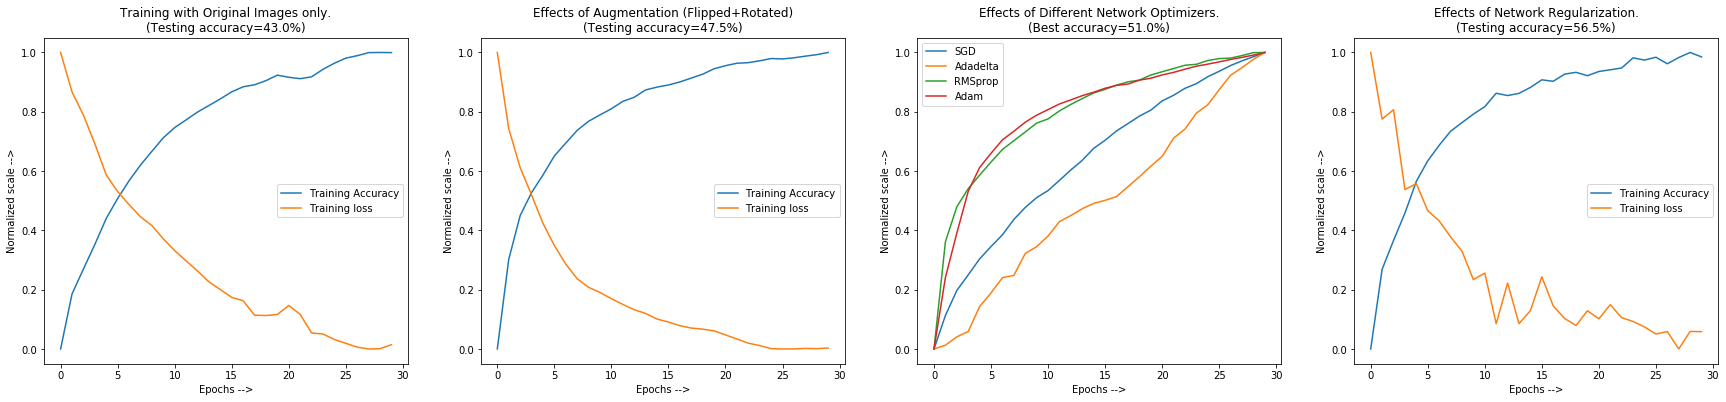

In [0]:
"""
Analysing trends of loss and accuracy for each executed model
"""

def normalize_logs(data):
  return (data-data.min())/(data.max()-data.min())

acc0 = normalize_logs(np.array(acc0))
acc1 = normalize_logs(np.array(acc1))
acc21 = normalize_logs(np.array(acc21))
acc22 = normalize_logs(np.array(acc22))
acc23 = normalize_logs(np.array(acc23))
acc24 = normalize_logs(np.array(acc24))
acc3 = normalize_logs(np.array(acc3))

loss0 = normalize_logs(np.array(loss0))
loss1 = normalize_logs(np.array(loss1))
loss3 = normalize_logs(np.array(loss3))

f1 = plt.figure(figsize=(30,6))

f1.add_subplot(1,4,1)
plt.title("Training with Original Images only.\n(Testing accuracy={}%)".format(test_acc0))
plt.plot(acc0, label="Training Accuracy")
plt.plot(loss0, label="Training loss")
plt.xlabel("Epochs -->")
plt.ylabel("Normalized scale -->")
plt.legend()

f1.add_subplot(1,4,2)
plt.title("Effects of Augmentation (Flipped+Rotated)\n(Testing accuracy={}%)".format(test_acc1))
plt.plot(acc1, label="Training Accuracy")
plt.plot(loss1, label="Training loss")
plt.xlabel("Epochs -->")
plt.ylabel("Normalized scale -->")
plt.legend()

f1.add_subplot(1,4, 3)
plt.title("Effects of Different Network Optimizers.\n(Best accuracy={}%)".format(test_acc24))
plt.plot(acc21, label="SGD")
plt.plot(acc22, label="Adadelta")
plt.plot(acc23, label="RMSprop")
plt.plot(acc24, label="Adam")
plt.xlabel("Epochs -->")
plt.ylabel("Normalized scale -->")
plt.legend()

f1.add_subplot(1,4, 4)
plt.title("Effects of Network Regularization.\n(Testing accuracy={}%)".format(test_acc3))
plt.plot(acc3, label="Training Accuracy")
plt.plot(loss3, label="Training loss")
plt.xlabel("Epochs -->")
plt.ylabel("Normalized scale -->")
plt.legend()
plt.show(block=True)

### Saving the generated logs
# file = open("Training_logs.pkl", "wb")
# pickle.dump(acc0, file)
# pickle.dump(acc1, file)
# pickle.dump(acc21, file)
# pickle.dump(acc22, file)
# pickle.dump(acc23, file)
# pickle.dump(acc24, file)
# pickle.dump(acc3, file)
# pickle.dump(loss0, file)
# pickle.dump(loss1, file)
# pickle.dump(loss21, file)
# pickle.dump(loss22, file)
# pickle.dump(loss23, file)
# pickle.dump(loss24, file)
# pickle.dump(loss3, file)
# file.close()

# Inferences from plots
Comparing every plot with the results of Baseline model,  
- **Augmentation improved the accuracy**. Moreover, accuracy improved faster as compared to baseline model.
- **Different optimizers have varying effects on training**. Adam and RMSprop optimizers had nearly similar effects. on the other hand, Adadelta resulted in worst results.
- **Network Regularization increases model performance and accuracy**. Trends in training-loss reflect the model struggling to learn due to random switches in connections between layers.


<hr>
<hr>


## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

{Bonus: 10 points} Bonus will be given to those who fine-tune the [VGG network](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html) [paper](https://arxiv.org/pdf/1409.1556.pdf) and compare performance with AlexNet. Explain why VGG performed better or worse.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [0]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num,
                                     zero_centered=True, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

In [0]:
# file = open('largeloader.pkl', 'wb')
# pickle.dump(trainloader_large, file)
# pickle.dump(testloader_large, file)
# file.close()

file = open('largeloader.pkl', 'rb')
trainloader_large = pickle.load(file)
testloader_large = pickle.load(file)
file.close()

<hr>
<hr>
<hr>
<hr>

# **Solution of Problem 2**

> Note:- All the CNN models are trained with **GPU enabled**, hence the processing time is very lesss.

## <u>Part 1 - Using existing CNN model: The two strategies</u>

### 2.1.1 <u>Strategy A</u>
**Statement**- Use first 200 sampled activations from last second layer of alex-net as featues and train a linear SVM classifier with those activations as bag-of-features. <br>
**Implementation**- For this task, a pretrained alex-net was loaded from ```torchvision.models``` and its last two layres- ```ReLU(inplace=True)``` and ``` Linear(in_features=4096, out_features=1000)``` were removed. Hence, revealing the 2nd last layer ``` Linear(in_features=4096, out_features=4096)``` as the final layer of the model. <br>
Entire trainig and testing data was foward-passed through this network and outputs were stored as train and test features respectively. These features were used for training a ```sklearn.svm.LinearSVC``` classifier with regularization parameter ```C=0.001```, which gave the following results:- <br>
```
Accuracy      =   78.75%
Training Time =   0.791824 sec
Eval Time     =   0.001375 sec
```

### 2.1.2 <u>Strategy B</u>
**Statement**- Fine-tune a pre-trained alex-net by modifying some of its final layers. <br>
**Implementation**- The final layer of alex-net contains 1000 outputs corrosponding to the classes of ImageNet challenge. Since our classification task has 16 distinct classes, and the last layers of Alex-net is highly object specific; **the last 2 layers are removed and replaced with following 2 layers**:- <br>
1. ```Linear(in_features=4096, out_features=1024, bias=True)``` followed by ```ReLU``` activation and<br>
2. ```Linear(in_features=1024, out_features=16, bias=True)``` as the final layer. <br>
Therefore, the final classification layers of AlexNet looks as follows-
```
(classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=4096, out_features=1024, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=1024, out_features=16, bias=True)
)
```
> Note:- I had selected ```epochs=15``` (instead of 30-epochs used in previous problem) for fine-tuning **because for ```epochs >15```, model was observed to overfit, hence reducing model-test accuracy**.<br>

By fine-tuning alexnet for only 15-epochs, following results were achieved **which are much higher than previous CNN-models trained from scratch**
```
Accuracy      =   72.7500%
Training Time =   86.4120 sec
Eval Time     =   0.3268 sec
```
<hr>

## <u>Part 2 - Again implement Strategy A with all 4096 activations as features</u>
Following the same procedure from 2.1.1 but instead of sampling first 200 activations, all the 4096 activations from last 2nd layer of AlexNet are considered as features. <br>
These features are used to train a ```sklearn.multiclass.OneVsRestClassifier``` classifier over ```sklearn.svm.SVC``` classifier with regularization parameter ```C=0.0001``` . <br>
Following results were achieved-
```
Accuracy      =   83.75 %
Training Time =   47.5743 sec
Eval Time     =   6.33898 sec
```
<hr>

## <u>Bonus Task</u>
**Statement**- Fine-tune VGG net from ```torchvision.models.VGG``` and compare its performance with AlexNet fine-tuned in 2.1.2 <br>
**Implementation**- Among all the varients of VGG-net, ```VGG11_bn``` model was selected due to presence of few BatchNormalization layers between feature extraction layers and it had comparitively lesser layers than all other varients. <br>
For fair comparision between the performance of the 2 pretrained models, the classification-layers of VGG model were made similar to those layer-modifications done with AlexNet in 2.1.2. Outputs were managed accordingly. <br>
The final classification layers for pretrained VGG net are- <br>
```
(classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=25088, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=4096, out_features=1024, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=1024, out_features=16, bias=True)
)

```
Fine-tuning VGG-net gave following results which is **highest compared to all the CNN-models trained in this session.** <br>
```
Accuracy      =   79.2500 %
Training Time =   647.8930 sec
Eval Time     =   2.2239 sec
```

### <u>Comparision between AlexNet and VGG-Net performance </u>
For the same classifier layers and number of trainig epochs, **it is observed that ```VGG11_bn``` model results in higher accuracy than ```alexnet```**. This was achieved at the cost of time. **```VGG11_bn``` had consumed comparitively a lot more time for trainng and evaluation than ```alexnet```**. <br>
Possible reasons for VGG being superioir to alexNet- <br>
1. ```VGG11_bn``` had Batch Normalisation layers embedded between ```Conv2d``` layers. This normalisation may help the model with faster and better feature extraction.
2. ```VGG11_bn``` is is more deep, i.e. its feature extractor is ```nn.Sequential``` layer with 28-internal layers for feature extraction compared to 12-internal layers in ```alexnet```. This may end up more filtered feature extraction by ```VGG_bn``` model. Due to this reason, test-accuracy of ```VGG11_bn``` was more and consequently time consumed was higher.

In [0]:
# ===============================================
#         Problem 2: Part 1.1
#
#         Implement Strategy A-
#   Use first 200 activations from last 2nd layer of alexNet as features
#   and train a SVM classifier with it.
# ===============================================

# Loading pretrained alexnet and removing its last 2 layers
feature_net = torchvision.models.alexnet(pretrained=True)
feature_net.classifier  = nn.Sequential(*(list(feature_net.classifier.children())[:5]))
print(feature_net)

# Extracting individual train features by forward-passing data through the pretrained-net
train_features = np.zeros((0, 200))
train_labels = list()
for i, data in enumerate(trainloader_large):
  images, labels = data
  outputs = feature_net(images.float())
  for j, output in enumerate(outputs.data):
    train_features = np.vstack((train_features, np.array(output[:200])))
    train_labels.append(np.array(labels[j]))

# Extracting individual test features by forward-passing data through the pretrained-net
test_features = np.zeros((0, 200))
test_labels = list()
for i, data in enumerate(testloader_large):
  images, labels = data
  outputs = feature_net(images.float())
  for j, output in enumerate(outputs.data):
    test_features = np.vstack((test_features, np.array(output[:200])))
    test_labels.append(np.array(labels[j]))

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:02<00:00, 106MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
# Training the generated features using Linear SVM classifier
from sklearn.svm import LinearSVC

t0 = time.time()
classifier = LinearSVC(random_state=0, C=0.001)
classifier.fit(train_features, train_labels)
t_train = time.time() - t0
accuracy = classifier.score(test_features, test_labels)
t_eval = (time.time() - t0) - t_train
print("Accuracy of activation-features with LinearSVC is {}% and training and eval times are {} sec & {} sec resp.".format(accuracy*100, t_train, t_eval))

Accuracy of activation-features with LinearSVC is 78.75% and training and eval times are 0.7918243408203125 sec & 0.001375436782836914 sec resp.


In [0]:
# ===============================================
#         Problem 2: Part 1.2
#
#         Implement Strategy B-
#   Fine-Tune Pretrained Network (Alex Net)
# ===============================================

# Loading the pretrained alexnet
alexNet = torchvision.models.alexnet(pretrained=True)

# Replacing the last 2 layers of alexnet
base = list(alexNet.classifier.children())
replacement = [
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 16)
]
extended_classifier = base[:3] + replacement
alexNet.classifier = nn.Sequential(*(extended_classifier))

print(alexNet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
# Fine-tuning the modified alexnet with same train-function used in previous problem
net = alexNet
loss_fn = nn.CrossEntropyLoss()
epochs = 15
optimizer = optim.Adam(net.parameters())
acc5, loss5, alexNet_train_time = train_network(net, loss_fn, trainloader_large, epochs, optimizer)
test_accuracy, alexNet_eval_time = evaluate_model(net, testloader_large)
print("Model accuracy= {:.4f}. Training Time= {:.4f} sec and Evaluation time={:.4f} sec".format(test_accuracy, alexNet_train_time, alexNet_eval_time))

GPU enabled training = True
Epoch = 1,	Loss = 2.2586,	Training accuracy = 13.7500
Epoch = 2,	Loss = 2.2114,	Training accuracy = 18.7917
Epoch = 3,	Loss = 1.5906,	Training accuracy = 42.4583
Epoch = 4,	Loss = 1.1275,	Training accuracy = 54.0833
Epoch = 5,	Loss = 0.8481,	Training accuracy = 63.4583
Epoch = 6,	Loss = 1.2755,	Training accuracy = 63.9583
Epoch = 7,	Loss = 1.0725,	Training accuracy = 70.0417
Epoch = 8,	Loss = 1.0403,	Training accuracy = 73.0000
Epoch = 9,	Loss = 1.1064,	Training accuracy = 77.7917
Epoch = 10,	Loss = 0.5474,	Training accuracy = 78.0000
Epoch = 11,	Loss = 0.9236,	Training accuracy = 83.0417
Epoch = 12,	Loss = 0.4922,	Training accuracy = 82.2500
Epoch = 13,	Loss = 0.5067,	Training accuracy = 84.2917
Epoch = 14,	Loss = 0.3808,	Training accuracy = 86.9583
Epoch = 15,	Loss = 0.6247,	Training accuracy = 87.2917
**** TOTAL TRAINING TIME : 86.412 sec.*****
Model accuracy= 72.7500. Training Time= 86.4120 sec and Evaluation time=0.3268 sec


In [0]:
# ===================================================
#         Problem 2: Part 2
#
#         Implement Strategy A again-
#   Use all 4096 features from alexNet as features
#   and classify them using OneVsRest SVM classifier.
# ===================================================

# Loading pretrained alexnet and removing its last 2 layers
feature_net = torchvision.models.alexnet(pretrained=True)
feature_net.classifier  = nn.Sequential(*(list(feature_net.classifier.children())[:5]))
print(feature_net)

# Extracting individual train features by forward-passing data through the pretrained-net
train_featuresB = np.zeros((0, 4096))
train_labelsB = list()
for i, data in enumerate(trainloader_large):
  images, labels = data
  outputs = feature_net(images.float())
  for j, output in enumerate(outputs.data):
    train_featuresB = np.vstack((train_featuresB, np.array(output)))
    train_labelsB.append(labels[j].item())

# Extracting individual test features by forward-passing data through the pretrained-net
test_featuresB = np.zeros((0, 4096))
test_labelsB = list()
for i, data in enumerate(testloader_large):
  images, labels = data
  outputs = feature_net(images.float())
  for j, output in enumerate(outputs.data):
    test_featuresB = np.vstack((test_featuresB, np.array(output)))
    test_labelsB.append(labels[j].item())

# Converting the labels from list to np.array datatypes
train_labelsB = np.array(train_labelsB)
test_labelsB = np.array(test_labelsB)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
# Training the generated features using multiclass.OneVsRest classifier ober svm.SVC classifier with C=0.0001
from sklearn import multiclass, svm

t0B = time.time()
classifierB = multiclass.OneVsRestClassifier(svm.SVC(C=0.0001, kernel='linear')).fit(train_featuresB, train_labelsB)
train_timeB = time.time() - t0B
accuracyB = classifierB.score(test_featuresB, test_labelsB)
eval_timeB = (time.time() - t0B) - train_timeB
print("Accuracy of 4096-activation features with OneVsRest SVM classifier is {}% and training and eval times are {}sec & {}sec resp.".format(accuracyB*100, train_timeB, eval_timeB))

Accuracy of 4096-activation features with OneVsRest SVM classifier is 83.75% and training and eval times are 47.57431435585022sec & 6.338985204696655sec resp.


In [0]:
# ===============================================
#           Bonus Task
#
#   Fine-Tune Pretrained VGG Net and
#      compare it with Alex Net
# ===============================================

# Loading the pre-trained VGG net
vgg = torchvision.models.vgg11_bn(pretrained=True)

# Replacing the classifier of VGG such that it is similar to the one used earlier with alexnet.
# This same configuration is used for fair comparision.
baseVGG = list(vgg.classifier.children())
replacement = [
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 16)
]
extendedVGG_classifier = [replacement[0]] + baseVGG[:2] + replacement[1:]
vgg.classifier = nn.Sequential(*(extendedVGG_classifier))

print(vgg)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:36<00:00, 14.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [0]:
# Fine-tuning the modified VGG-net with same training function used in previous problem.
BonusNet = vgg
loss_fn = nn.CrossEntropyLoss()
epochs = 15
optimizer = optim.Adam(BonusNet.parameters())
acc5, loss5, vggNet_train_time = train_network(BonusNet, loss_fn, trainloader_large, epochs, optimizer)
test_accuracy, vggNet_eval_time = evaluate_model(BonusNet, testloader_large)
print("Model accuracy= {:.4f}. Training Time= {:.4f} sec and Evaluation time={:.4f} sec".format(test_accuracy, vggNet_train_time, vggNet_eval_time))

GPU enabled training = True
Epoch = 1,	Loss = 0.8184,	Training accuracy = 63.6667
Epoch = 2,	Loss = 0.3433,	Training accuracy = 81.4583
Epoch = 3,	Loss = 0.8898,	Training accuracy = 84.7917
Epoch = 4,	Loss = 0.3883,	Training accuracy = 89.2917
Epoch = 5,	Loss = 0.1488,	Training accuracy = 93.0417
Epoch = 6,	Loss = 0.2674,	Training accuracy = 94.4167
Epoch = 7,	Loss = 0.1184,	Training accuracy = 93.9167
Epoch = 8,	Loss = 0.1048,	Training accuracy = 94.4583
Epoch = 9,	Loss = 0.2406,	Training accuracy = 89.5833
Epoch = 10,	Loss = 0.1524,	Training accuracy = 94.7083
Epoch = 11,	Loss = 0.0091,	Training accuracy = 96.5000
Epoch = 12,	Loss = 0.1533,	Training accuracy = 97.0000
Epoch = 13,	Loss = 0.2458,	Training accuracy = 98.0417
Epoch = 14,	Loss = 0.0981,	Training accuracy = 97.0000
Epoch = 15,	Loss = 0.2537,	Training accuracy = 96.7917
**** TOTAL TRAINING TIME : 647.893 sec.*****
Model accuracy= 79.2500. Training Time= 647.8930 sec and Evaluation time=2.2239 sec


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw4' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.py
        |---Surname_Givenname_SBUID_hw*.pdf
```
where Surname_Givenname_SBUID_hw*.py is the Python code of Surname_Givenname_SBUID_hw*.ipynb, which can be dowloaded by File->Download .py.

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw4.zip" for homework4 in this structure:
```
Jordan_Michael_111134567_hw4
        |---Jordan_Michael_111134567_hw4.ipynb
        |---Jordan_Michael_111134567_hw4.py
        |---Jordan_Michael_111134567_hw4.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link** and **Surname_Givenname_SBUID_Pred*.pdf** should be your test set prediction file in the specified format. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter two TA's emails: ***bo.cao.1@stonybrook.edu*** and ***sayontan.ghosh@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.